The model created in this notebook is built to classify whether a news is a fake news or not based on its title. The dataset used in this notebook is [BIRDS 450 SPECIES- IMAGE CLASSIFICATION](https://www.kaggle.com/datasets/gpiosenka/100-bird-species) by GERRY posted on Kaggle. 

Libraries used in this notebook are:
* Tensorflow, for creating deep learning model
* OS, for manipulating dataset
* Matplotlib, for visualization

# Download Dataset via Kaggle

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d gpiosenka/100-bird-species

100% 1.69G/1.69G [01:22<00:00, 25.0MB/s]
100% 1.69G/1.69G [01:22<00:00, 21.9MB/s]


In [ ]:
! unzip 100-bird-species.zip 

Streaming output truncated to the last 5000 lines.
  inflating: train/VIOLET TURACO/129.jpg  
  inflating: train/VIOLET TURACO/130.jpg  
  inflating: train/VIOLET TURACO/131.jpg  
  inflating: train/VIOLET TURACO/132.jpg  
  inflating: train/VIOLET TURACO/133.jpg  
  inflating: train/VIOLET TURACO/134.jpg  
  inflating: train/VIOLET TURACO/135.jpg  
  inflating: train/VIOLET TURACO/136.jpg  
  inflating: train/VIOLET TURACO/137.jpg  
  inflating: train/VIOLET TURACO/138.jpg  
  inflating: train/VIOLET TURACO/139.jpg  
  inflating: train/VIOLET TURACO/140.jpg  
  inflating: train/VIOLET TURACO/141.jpg  
  inflating: train/VIOLET TURACO/142.jpg  
  inflating: train/VIOLET TURACO/143.jpg  
  inflating: train/VIOLET TURACO/144.jpg  
  inflating: train/VIOLET TURACO/145.jpg  
  inflating: train/VIOLET TURACO/146.jpg  
  inflating: train/VIOLET TURACO/147.jpg  
  inflating: train/VIOLET TURACO/148.jpg  
  inflating: train/VIOLET TURACO/149.jpg  
  inflating: train/VIOLET TURACO/150.jpg  
  i

# Import Dependencies

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import os

untuk mempercepat proses training maka disini saya hanya akan menggunakan 25 class

# Load the Dataset

In [ ]:
train_path = '/content/train'
validation_path = '/content/valid'

TARGET_SIZE = 224
BATCH_SIZE = 128

In [ ]:
classes = os.listdir(train_path)[:25]
train_class_paths = [os.path.join(train_path, i) for i in os.listdir(train_path)][:20]
validation_class_paths = [os.path.join(validation_path, i) for i in os.listdir(validation_path)][:20]

In [ ]:
new_train_path = '/content/train20'
new_validation_path = '/content/valid20'

os.mkdir(new_train_path)
os.mkdir(new_validation_path)

sebelum dapat memasukkan data kedalam generator, terlebih dahulu kita akan menghandle dataset terlebih dahulu, karena dalam dataset masih terdapat subfolder-subfolder, oleh karena itu file-file gambar akan dipindahkan kedalam folder-folder baru

In [ ]:
train_content_list = {}
validation_content_list = {}

for val in classes:
    train_dir_path = os.path.join(train_path, val)
    validation_dir_path = os.path.join(validation_path, val)

    train_files = os.listdir(train_dir_path)
    validation_files = os.listdir(validation_dir_path)

    train_content_list[val] = [os.path.join(train_dir_path, i) for i in train_files]
    validation_content_list[val] = [os.path.join(validation_dir_path, i) for i in validation_files]

In [ ]:
import shutil

for cls in classes:
    new_train_dir_path = os.path.join(new_train_path, cls)
    new_validation_dir_path = os.path.join(new_validation_path, cls)

    os.mkdir(new_train_dir_path)
    os.mkdir(new_validation_dir_path)

    for fl in train_content_list[cls]:
        shutil.move(fl, new_train_dir_path)

    for fl in validation_content_list[cls]:
        shutil.move(fl, new_validation_dir_path)



In [ ]:
train_path = new_train_path
validation_path = new_validation_path
NUMBER_OF_CLASSES = len(os.listdir(train_path))

# Creating ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_val_generators(TRAINING_DIR, IMAGE_SIZE,BATCH_SIZE):
  train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    # shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest',
                                    validation_split=0.2)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                      subset='training')

  test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

  
  test_generator = test_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                    subset='validation')
  
  return train_generator, test_generator

In [ ]:
train_generator, validation_generator = train_val_generators(
            train_path, 
            TARGET_SIZE,
            BATCH_SIZE)

Found 3284 images belonging to 25 classes.
Found 807 images belonging to 25 classes.


# Modelling

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(TARGET_SIZE, TARGET_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax')  
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
# define callbacks
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        desired_acc = 0.92
        if (val_accuracy > desired_acc) and (accuracy > desired_acc):
            self.model.stop_training = True
            print('desired accuracy reached')

custom_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
      train_generator,
      epochs=100, 
      validation_data=validation_generator,
      callbacks=[myCallback(), custom_early_stopping]
      )

Epoch 1/100
26/26 [==============================] - 47s 1s/step - loss: 3.2191 - accuracy: 0.0402 - val_loss: 3.2082 - val_accuracy: 0.0520
Epoch 2/100
26/26 [==============================] - 39s 1s/step - loss: 3.1687 - accuracy: 0.0649 - val_loss: 3.1212 - val_accuracy: 0.0520
Epoch 3/100
26/26 [==============================] - 38s 1s/step - loss: 3.1196 - accuracy: 0.0810 - val_loss: 3.0442 - val_accuracy: 0.0917
Epoch 4/100
26/26 [==============================] - 39s 2s/step - loss: 3.0554 - accuracy: 0.0947 - val_loss: 2.9257 - val_accuracy: 0.1227
Epoch 5/100
26/26 [==============================] - 38s 1s/step - loss: 2.9918 - accuracy: 0.1023 - val_loss: 2.7933 - val_accuracy: 0.1475
Epoch 6/100
26/26 [==============================] - 38s 1s/step - loss: 2.8804 - accuracy: 0.1233 - val_loss: 2.6683 - val_accuracy: 0.1710
Epoch 7/100
26/26 [==============================] - 38s 1s/step - loss: 2.7993 - accuracy: 0.1410 - val_loss: 2.5942 - val_accuracy: 0.1945
Epoch 8/100
2

# Plot the Result

In [ ]:
# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

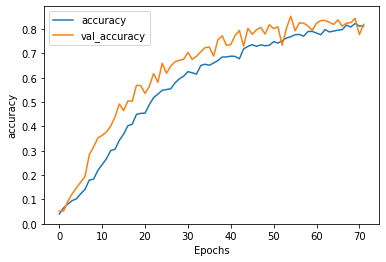

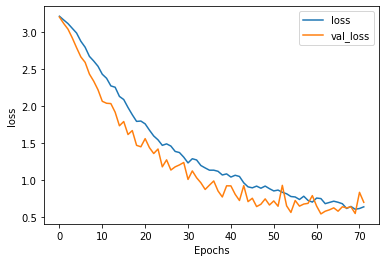

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Saving Model into TFLite format

In [ ]:
import pathlib

# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)
 
# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('image_classifier.tflite')
tflite_model_file.write_bytes(tflite_model)

7401408